# Image Classification with SVMs + Augmentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
import csv

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection importRandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.svm import LinearSVC

2023-04-19 06:50:50.928574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 06:50:54.477123: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-19 06:51:02.835640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-19 06:51:02.836112: W tensorflow/strea

### Load Dataset

In [2]:
%%time

# Load the compressed array from disk
images_mini = np.load('CNN_Xs_downsample_forvgg16.npz')['data']

CPU times: user 10.7 s, sys: 1.16 s, total: 11.9 s
Wall time: 12.3 s


In [3]:
# load the labels from disk
with open('CNN_labels_downsampled_forvgg16.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [4]:
print('images_mini.shape:', images_mini.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 224, 224, 3)

number of labels: 5600

number of positive cancer cases: 600


### Normalize

In [5]:
print('Original max pixel value:', images_mini.max())
print('Confirm min pixel value is 0:', images_mini.min())

Original max pixel value: 255.0
Confirm min pixel value is 0: 0.0


In [6]:
#Normalize image pixel values
images_mini_norm = images_mini / images_mini.max() 

In [7]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 1.0
Confirm min pixel value is 0: 0.0


### Reshape

In [8]:
images_mini_norm.shape

(5600, 224, 224, 3)

In [9]:
arr_mean = np.mean(images_mini_norm, axis=-1)
arr_mean.shape
resized_images_mini = np.expand_dims(arr_mean, axis=-1)
resized_images_mini.shape

(5600, 224, 224, 1)

In [10]:
print('Original max pixel value:', resized_images_mini.max())
print('Confirm min pixel value is 0:', resized_images_mini.min())

Original max pixel value: 1.0
Confirm min pixel value is 0: 0.0


## Settings

In [11]:
random_state = 1234

In [12]:
random.seed(random_state)
tf.random.set_seed(random_state)
np.random.seed(random_state)

### Inputs

In [13]:
X= resized_images_mini
y = y_mini

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train.shape

(4480, 224, 224, 1)

In [15]:
def preprocess_augm(X_train, y_train):
    
    # Augment only cancer=1 data
    X_train_w_cancer = X_train[y_train == 1, :, :, :]
    y_train_w_cancer = y_train[y_train == 1]
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm1 = tf.image.adjust_brightness(X_train_w_cancer, delta=.1)
    X_train_augm2 = tf.image.adjust_brightness(X_train_w_cancer, delta=.2)
    
    # adjust contrast
    X_train_augm5 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=1)
    X_train_augm6 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=2)

    # random flip
    X_train_augm8 = tf.image.random_flip_left_right(X_train_w_cancer)
    
    # concatenate augmented X_train data
    X_train_augm = tf.concat([X_train_augm1, X_train_augm2, X_train_augm5,
                        X_train_augm6, X_train_augm8],axis=0)
    order = []
    for i in range(5):
        order += [j for j in range(len(X_train_w_cancer))]
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = tf.convert_to_tensor(np.ones(len(X_train_augm)))
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train_augm)[0], dtype=tf.int32))
    X_train_augm = tf.gather(X_train_augm, shuffle)
    y_train_augm = tf.gather(y_train_augm, shuffle)
    
    shuffled_order = tf.gather(order, shuffle)

    return X_train_augm, y_train_augm, shuffled_order.numpy()



2023-04-19 06:51:38.861565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-19 06:51:38.866666: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-19 06:51:38.866724: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4d606448a931): /proc/driver/nvidia/version does not exist
2023-04-19 06:51:38.923704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

In [16]:
def preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, order, n_augm):
    X_train_augm = X_train_augm[0:n_augm]
    y_train_augm = y_train_augm[0:n_augm]
    selected_order = order[0:n_augm]
    
    X_train_order = [j for j in range(tf.shape(X_train)[0])]
    selected_order = np.concatenate((np.array(X_train_order), selected_order))
    
    
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    groups = tf.gather(selected_order, shuffle)
    
    return X_train, y_train, groups.numpy()

In [ ]:
# Run the function
# preprocess_augm(X_train, y_train)
X_train_augm, y_train_augm, order = preprocess_augm(X_train, y_train)

In [17]:
num_augmented_images = 1800
X_train, y_train, groups = preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, order, n_augm=num_augmented_images)

In [18]:
# reshape
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

In [19]:
X_train.shape

(6280, 50176)

## Build Model

In [20]:
param_dist = {
    'C': np.logspace(-4, 4, 5),
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l1', 'l2'],
    'dual': [False],
    'tol': np.logspace(-6, -1, 5)
}

In [21]:
svm_classifier = LinearSVC()

In [22]:
X_train.shape

(6280, 50176)

In [23]:
y_train.shape

(6280,)

In [24]:
grid_search = RandomizedSearchCV(
    svm_classifier, 
    param_distributions=param_dist, 
    cv=StratifiedGroupKFold(5),
    scoring='f1',
    n_jobs=8,
    verbose=20,
    n_iter=100,
    return_train_score=True,
)

grid_search.fit(X_train, y_train, groups=groups)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


terminate called after throwing an instance of 'std::bad_alloc'
  what():  std::bad_alloc
exception calling callback for <Future at 0x7f15b8061510 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 556, in 

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6)}

In [ ]:
# print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [ ]:
model_name = 'linearsvc_augmented'

# convert the results to a pandas DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# save the results to a CSV file
cv_results.to_csv(f'results/{model_name}_crossvalidation_results.csv', index=False)

In [ ]:
res = pd.read_csv('results/randomforest_augmented_crossvalidation_results.csv')

In [ ]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']


import seaborn as sns
for param_name in params[0].keys():
    # Extract the scores and hyperparameter values for the current parameter
    
    values = [pdict[param_name] for pdict in params]
    
    # Create a boxplot
    plt.figure()
    sns.boxplot(x=values, y=scores)
    plt.xlabel(param_name)
    plt.ylabel('f1_score')
    plt.show()

### Scoring

In [ ]:
# grid_search.best_params_
# hyperparam = {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}


hyperparam = {'tol': 1.778279410038923e-05, 'penalty': 'l2', 'loss': 'squared_hinge', 'dual': False, 'C': 0.01}

In [ ]:
tuned_clf = LinearSVC(
    **hyperparam, #grid_search.best_params_
)

In [ ]:
tuned_clf.fit(X_train, y_train)

LinearSVC(C=0.01, dual=False, tol=1.778279410038923e-05)

In [ ]:
train_acc = tuned_clf.score(X_train, y_train)
print(f"Train accuracy score: {train_acc:.3f}")

# Evaluate the test accuracy
test_cc = tuned_clf.score(X_test, y_test)
print(f"Test accuracy score: {test_cc:.3f}")

Train accuracy score: 0.990
Test accuracy score: 0.871


In [ ]:
y_pred_train = tuned_clf.predict(X_train)
y_pred_test = tuned_clf.predict(X_test)

In [ ]:
train_roc = roc_auc_score(y_train, y_pred_train)
print(f"Train ROC_AUC score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = roc_auc_score(y_test, y_pred_test)
print(f"Test ROC_AUC score: {test_roc:.3f}")

Train ROC_AUC score: 0.966
Test ROC_AUC score: 0.506


In [ ]:
train_roc = precision_score(y_train, y_pred_train)
print(f"Train precision score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = precision_score(y_test, y_pred_test)
print(f"Test precision score: {test_roc:.3f}")


Train precision score: 1.000
Test precision score: 0.143
Train recall score: 0.932
Test recall score: 0.042


In [ ]:
train_roc = recall_score(y_train, y_pred_train)
print(f"Train recall score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = recall_score(y_test, y_pred_test)
print(f"Test recall score: {test_roc:.3f}")

In [ ]:
train_roc = f1_score(y_train, y_pred_train)
print(f"Train f1 score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = f1_score(y_test, y_pred_test)
print(f"Test f1 score: {test_roc:.3f}")

Train f1 score: 0.529
Test f1 score: 0.000


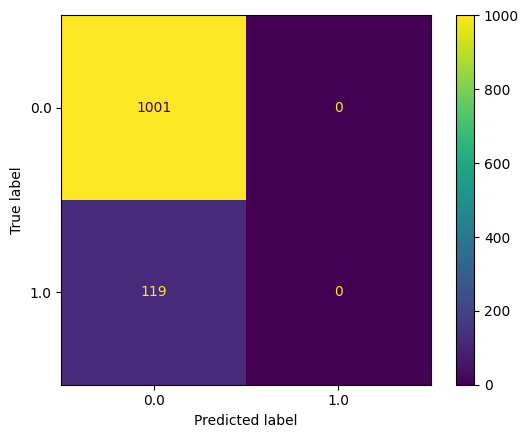

In [ ]:

cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tuned_clf.classes_
)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      3999
         1.0       1.00      0.36      0.53       681

    accuracy                           0.91      4680
   macro avg       0.95      0.68      0.74      4680
weighted avg       0.92      0.91      0.89      4680



In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1001
           1       0.00      0.00      0.00       119

    accuracy                           0.89      1120
   macro avg       0.45      0.50      0.47      1120
weighted avg       0.80      0.89      0.84      1120



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
